In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import lightgbm as lgb
import optuna.integration.lightgbm as lgb
import seaborn as sns
#from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [4]:
dataset = pd.read_csv('train.tsv', sep='\t')
test_data = pd.read_csv('test.tsv', sep='\t')
dataset

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx
1,3,18.0,6,171.0,97,2984,14.5,75,1,ford pinto
2,9,32.7,6,168.0,132,2910,11.4,80,3,datsun 280-zx
3,11,38.1,4,89.0,60,1968,18.8,80,3,toyota corolla tercel
4,13,28.0,4,98.0,80,2164,15.0,72,1,dodge colt (sw)
...,...,...,...,...,...,...,...,...,...,...
194,384,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510
195,385,26.0,4,79.0,67,1963,15.5,74,2,volkswagen dasher
196,387,29.0,4,135.0,84,2525,16.0,82,1,dodge aries se
197,395,31.3,4,120.0,75,2542,17.5,80,3,mazda 626


In [5]:
#文字列をspritした頭を抽出
dataset['bland'] = dataset['car name'].apply(lambda x: x.split(' ')[0])
test_data['bland'] = test_data['car name'].apply(lambda x: x.split(' ')[0])
dataset

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland
0,0,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx,datsun
1,3,18.0,6,171.0,97,2984,14.5,75,1,ford pinto,ford
2,9,32.7,6,168.0,132,2910,11.4,80,3,datsun 280-zx,datsun
3,11,38.1,4,89.0,60,1968,18.8,80,3,toyota corolla tercel,toyota
4,13,28.0,4,98.0,80,2164,15.0,72,1,dodge colt (sw),dodge
...,...,...,...,...,...,...,...,...,...,...,...
194,384,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510,datsun
195,385,26.0,4,79.0,67,1963,15.5,74,2,volkswagen dasher,volkswagen
196,387,29.0,4,135.0,84,2525,16.0,82,1,dodge aries se,dodge
197,395,31.3,4,120.0,75,2542,17.5,80,3,mazda 626,mazda


In [6]:
#データフレーム全体で"?"の要素をNaNに変換
dataset = dataset.mask(dataset  == "?")
test_data = test_data.mask(test_data  == "?")
#各行でNaNをカウント
dataset.isnull().sum()

Unnamed: 0      0
mpg             0
cylinders       0
displacement    0
horsepower      3
weight          0
acceleration    0
model year      0
origin          0
car name        0
bland           0
dtype: int64

In [7]:
#文字列をspritした頭を抽出
dataset['bland'] = dataset['car name'].apply(lambda x: x.split(' ')[0])
test_data['bland'] = test_data['car name'].apply(lambda x: x.split(' ')[0])
dataset

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland
0,0,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx,datsun
1,3,18.0,6,171.0,97,2984,14.5,75,1,ford pinto,ford
2,9,32.7,6,168.0,132,2910,11.4,80,3,datsun 280-zx,datsun
3,11,38.1,4,89.0,60,1968,18.8,80,3,toyota corolla tercel,toyota
4,13,28.0,4,98.0,80,2164,15.0,72,1,dodge colt (sw),dodge
...,...,...,...,...,...,...,...,...,...,...,...
194,384,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510,datsun
195,385,26.0,4,79.0,67,1963,15.5,74,2,volkswagen dasher,volkswagen
196,387,29.0,4,135.0,84,2525,16.0,82,1,dodge aries se,dodge
197,395,31.3,4,120.0,75,2542,17.5,80,3,mazda 626,mazda


In [8]:
hp_impute =dataset[~dataset['horsepower'].isna()]
hp_impute['horsepower'] = hp_impute['horsepower'].astype(int)
#df_corr = hp_impute.drop(["car name","bland","Unnamed: 0"],axis=1).corr() #カテゴリデータ以外の列同士の相関係数
#df_corr["horsepower"]
cylinders_gr_mean = hp_impute.groupby(['cylinders'])['horsepower'].mean() #cylinderの数でグループ分けした平均を代入したい
cylinders_gr_mean

cylinders
3     98.500000
4     79.115789
5     90.000000
6    100.380952
8    162.036364
Name: horsepower, dtype: float64

In [9]:
test_hp_impute =test_data[~test_data['horsepower'].isna()]
test_hp_impute['horsepower'] = test_hp_impute['horsepower'].astype(int)
test_cylinders_gr_mean = test_hp_impute.groupby(['cylinders'])['horsepower'].mean()
test_cylinders_gr_mean

cylinders
3    100.000000
4     77.519231
5     67.000000
6    102.658537
8    154.020833
Name: horsepower, dtype: float64

In [10]:
merge_dataset = pd.merge(dataset, cylinders_gr_mean, on='cylinders').sort_values(by='Unnamed: 0').reset_index(drop=True)
merge_dataset = merge_dataset.rename(columns={'horsepower_x': 'horsepower', 'horsepower_y': 'horsepower_mean'})
merge_dataset
merge_dataset['horsepower'] = merge_dataset['horsepower'].fillna(merge_dataset['horsepower_mean'])  
merge_dataset.loc[[25,80,176]]#.isna().sum() #代入できているか確認

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland,horsepower_mean
25,50,40.9,4,85.0,79.115789,1835,17.3,80,2,renault lecar deluxe,renault,79.115789
80,166,34.5,4,100.0,79.115789,2320,15.8,81,2,renault 18i,renault,79.115789
176,351,23.6,4,140.0,79.115789,2905,14.3,80,1,ford mustang cobra,ford,79.115789


In [11]:
merge_test_data = pd.merge(test_data, test_cylinders_gr_mean, on='cylinders').sort_values(by='Unnamed: 0').reset_index(drop=True)
merge_test_data = merge_test_data.rename(columns={'horsepower_x': 'horsepower', 'horsepower_y': 'horsepower_mean'})
#merge_test_data
merge_test_data['horsepower'] = merge_test_data['horsepower'].fillna(merge_test_data['horsepower_mean'])  
merge_test_data.loc[[50,85,181]]#.isna().sum()

,Unnamed: 0,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland,horsepower_mean
50,101,4,151.0,77.519231,3035,20.5,82,1,amc concord dl,amc,77.519231
85,164,6,200.0,102.658537,2875,17.0,74,1,ford maverick,ford,102.658537
181,363,4,98.0,77.519231,2046,19.0,71,1,ford pinto,ford,77.519231


In [15]:
train=merge_dataset.drop(["Unnamed: 0","car name",'horsepower_mean'],axis=1)
test=merge_test_data.drop(["Unnamed: 0","car name",'horsepower_mean'],axis=1)
train

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,bland
0,39.4,4,85.0,70,2070,18.6,78,3,datsun
1,18.0,6,171.0,97,2984,14.5,75,1,ford
2,32.7,6,168.0,132,2910,11.4,80,3,datsun
3,38.1,4,89.0,60,1968,18.8,80,3,toyota
4,28.0,4,98.0,80,2164,15.0,72,1,dodge
...,...,...,...,...,...,...,...,...,...
194,27.0,4,97.0,88,2130,14.5,70,3,datsun
195,26.0,4,79.0,67,1963,15.5,74,2,volkswagen
196,29.0,4,135.0,84,2525,16.0,82,1,dodge
197,31.3,4,120.0,75,2542,17.5,80,3,mazda


# カテゴリ変数をEnconding

In [24]:
import category_encoders as ce
# 出現回数が3未満のカテゴリを"Rare"として結合
threshold = 3
train['bland'] = train['bland'].apply(lambda x: x if train['bland'].value_counts()[x] > threshold else 'Rare')
test['bland'] = test['bland'].apply(lambda x: x if test['bland'].value_counts()[x] > threshold else 'Rare')

train['horsepower'] = train['horsepower'].astype(float)
test['horsepower'] = test['horsepower'].astype(float)
#print(train['bland'].value_counts())

count_encoder = ce.CountEncoder(cols=['bland'])
train = count_encoder.fit_transform(train)
test = count_encoder.fit_transform(test)
test

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,bland
0,8,350.0,180.0,4499,12.5,73,1,6
1,4,156.0,105.0,2745,16.7,78,1,18
2,6,156.0,108.0,2930,15.5,76,3,14
3,4,108.0,70.0,2245,16.9,82,3,14
4,4,105.0,63.0,2125,14.7,82,1,18
...,...,...,...,...,...,...,...,...
194,8,305.0,140.0,4215,13.0,76,1,26
195,8,318.0,150.0,4237,14.5,73,1,18
196,8,350.0,145.0,4055,12.0,76,1,25
197,3,80.0,110.0,2720,13.5,77,3,6


# ここからLightGBM

In [39]:
columns = train.columns.tolist()
columns.remove('mpg')
X = train[columns] #説明変数
X['horsepower'] = X['horsepower'].astype(float)
#X['bland'] = X['bland'].astype('category') #object型はcategory型に直さないとダメ
y = train["mpg"] #目的変数

final_test = test[columns]
final_test['horsepower'] = final_test['horsepower'].astype(float)
#final_test['bland'] = final_test['bland'].astype('category') #object型はcategory型に直さないとダメ

X_train, X_test , y_train, y_test  = train_test_split(X      , y      , test_size=0.2, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)#categorical_feature=['bland']
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [41]:
#X.info()

In [42]:
# モデルの設定
# LightGBM のハイパーパラメータ
params = {
    # 目的関数
    'objective' : 'regression_l1',
    # MAE の最小化を目指す
    'metric': 'mae', #l1とmae同じ
    # Fatal の場合出力
    'verbosity': -1,
    # 乱数シード
    'seed': 31,
}

callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())

# モデルの学習
model = lgb.train(params, lgb_train, valid_sets=lgb_valid, callbacks=callbacks)

[I 2024-08-18 16:49:56,455] A new study created in memory with name: no-name-19bb7b2e-e637-44a3-8ba7-91413491a5cc
feature_fraction, val_score: 2.058555:  57%|#########################7                   | 4/7 [00:00<00:00, 19.91it/s]

[1]	valid_0's l1: 6.13453
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.62928
[3]	valid_0's l1: 5.19012
[4]	valid_0's l1: 4.80277
[5]	valid_0's l1: 4.46928
[6]	valid_0's l1: 4.18017
[7]	valid_0's l1: 3.93511
[8]	valid_0's l1: 3.75006
[9]	valid_0's l1: 3.53454
[10]	valid_0's l1: 3.41506
[11]	valid_0's l1: 3.28853
[12]	valid_0's l1: 3.13213
[13]	valid_0's l1: 2.95832
[14]	valid_0's l1: 2.81927
[15]	valid_0's l1: 2.72308
[16]	valid_0's l1: 2.61668
[17]	valid_0's l1: 2.55319
[18]	valid_0's l1: 2.48774
[19]	valid_0's l1: 2.44795
[20]	valid_0's l1: 2.39002
[21]	valid_0's l1: 2.35314
[22]	valid_0's l1: 2.33621
[23]	valid_0's l1: 2.31523
[24]	valid_0's l1: 2.27823
[25]	valid_0's l1: 2.23717
[26]	valid_0's l1: 2.1951
[27]	valid_0's l1: 2.16208
[28]	valid_0's l1: 2.16694
[29]	valid_0's l1: 2.15413
[30]	valid_0's l1: 2.14891
[31]	valid_0's l1: 2.14026
[32]	valid_0's l1: 2.12809
[33]	valid_0's l1: 2.133
[34]	valid_0's l1: 2.13377
[35]	valid_0's l1: 2.11911
[36]	v

feature_fraction, val_score: 2.019675: 100%|#############################################| 7/7 [00:00<00:00, 23.16it/s]


[1]	valid_0's l1: 6.11859
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.63128
[3]	valid_0's l1: 5.19273
[4]	valid_0's l1: 4.81395
[5]	valid_0's l1: 4.47303
[6]	valid_0's l1: 4.21738
[7]	valid_0's l1: 3.97883
[8]	valid_0's l1: 3.76413
[9]	valid_0's l1: 3.57509
[10]	valid_0's l1: 3.41173
[11]	valid_0's l1: 3.29369
[12]	valid_0's l1: 3.1662
[13]	valid_0's l1: 3.0013
[14]	valid_0's l1: 2.91079
[15]	valid_0's l1: 2.80926
[16]	valid_0's l1: 2.71789
[17]	valid_0's l1: 2.62185
[18]	valid_0's l1: 2.53671
[19]	valid_0's l1: 2.48009
[20]	valid_0's l1: 2.42913
[21]	valid_0's l1: 2.3886
[22]	valid_0's l1: 2.31905
[23]	valid_0's l1: 2.25645
[24]	valid_0's l1: 2.23525
[25]	valid_0's l1: 2.22244
[26]	valid_0's l1: 2.21091
[27]	valid_0's l1: 2.18166
[28]	valid_0's l1: 2.16135
[29]	valid_0's l1: 2.14177
[30]	valid_0's l1: 2.12668
[31]	valid_0's l1: 2.11431
[32]	valid_0's l1: 2.11166
[33]	valid_0's l1: 2.10983
[34]	valid_0's l1: 2.10763
[35]	valid_0's l1: 2.11958
[36]	v

num_leaves, val_score: 2.019675:  15%|#######5                                          | 3/20 [00:00<00:00, 26.51it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

[I 2024-08-18 16:49:56,890] Trial 9 finished with value: 2.0196748013275507 and parameters: {'num_leaves': 37}. Best is trial 7 with value: 2.0196748013275507.
num_leaves, val_score: 2.019675:  20%|##########                                        | 4/20 [00:00<00:00, 26.51it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

[I 2024-08-18 16:49:56,989] Trial 11 finished with value: 2.0196748013275507 and parameters: {'num_leaves': 42}. Best is trial 7 with value: 2.0196748013275507.
num_leaves, val_score: 2.019675:  30%|###############                                   | 6/20 [00:00<00:00, 20.94it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

[I 2024-08-18 16:49:57,110] Trial 13 finished with value: 2.0196748013275507 and parameters: {'num_leaves': 112}. Best is trial 7 with value: 2.0196748013275507.
num_leaves, val_score: 2.019675:  40%|####################                              | 8/20 [00:00<00:00, 20.94it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

num_leaves, val_score: 2.019675:  50%|########################5                        | 10/20 [00:00<00:00, 18.79it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

num_leaves, val_score: 2.019675:  55%|##########################9                      | 11/20 [00:00<00:00, 17.95it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

num_leaves, val_score: 2.019675:  65%|###############################8                 | 13/20 [00:00<00:00, 17.81it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

[I 2024-08-18 16:49:57,529] Trial 20 finished with value: 2.0196748013275507 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 2.0196748013275507.
num_leaves, val_score: 2.019675:  70%|##################################3              | 14/20 [00:00<00:00, 17.81it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887


num_leaves, val_score: 2.019675:  85%|#########################################6       | 17/20 [00:01<00:00, 16.38it/s]

[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's l1: 2.01967
[37]	valid_0's l1: 2.02899
[38]	valid_0's l1: 2.04579
[39]	valid_0's l1: 2.05962
[40]	valid_0's l1: 

[I 2024-08-18 16:49:57,796] Trial 24 finished with value: 2.0196748013275507 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 2.0196748013275507.
num_leaves, val_score: 2.019675: 100%|#################################################| 20/20 [00:01<00:00, 17.47it/s]


[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.8638
[8]	valid_0's l1: 3.66635
[9]	valid_0's l1: 3.45792
[10]	valid_0's l1: 3.29909
[11]	valid_0's l1: 3.1631
[12]	valid_0's l1: 3.0427
[13]	valid_0's l1: 2.88812
[14]	valid_0's l1: 2.78575
[15]	valid_0's l1: 2.6638
[16]	valid_0's l1: 2.566
[17]	valid_0's l1: 2.49299
[18]	valid_0's l1: 2.4272
[19]	valid_0's l1: 2.35545
[20]	valid_0's l1: 2.3146
[21]	valid_0's l1: 2.25002
[22]	valid_0's l1: 2.20671
[23]	valid_0's l1: 2.1763
[24]	valid_0's l1: 2.13526
[25]	valid_0's l1: 2.09471
[26]	valid_0's l1: 2.0779
[27]	valid_0's l1: 2.05721
[28]	valid_0's l1: 2.06488
[29]	valid_0's l1: 2.05213
[30]	valid_0's l1: 2.04116
[31]	valid_0's l1: 2.04388
[32]	valid_0's l1: 2.03669
[33]	valid_0's l1: 2.04717
[34]	valid_0's l1: 2.03092
[35]	valid_0's l1: 2.02633
[36]	valid_0's

bagging, val_score: 2.019675:  10%|#####3                                               | 1/10 [00:00<00:00, 13.60it/s]

[1]	valid_0's l1: 6.40875
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.79809
[3]	valid_0's l1: 5.41401
[4]	valid_0's l1: 5.03415
[5]	valid_0's l1: 4.72482
[6]	valid_0's l1: 4.46031
[7]	valid_0's l1: 4.16518
[8]	valid_0's l1: 3.90432
[9]	valid_0's l1: 3.73368
[10]	valid_0's l1: 3.56896
[11]	valid_0's l1: 3.45788
[12]	valid_0's l1: 3.29463
[13]	valid_0's l1: 3.17047
[14]	valid_0's l1: 3.03975
[15]	valid_0's l1: 2.95333
[16]	valid_0's l1: 2.86094
[17]	valid_0's l1: 2.81123
[18]	valid_0's l1: 2.75906
[19]	valid_0's l1: 2.69623
[20]	valid_0's l1: 2.67689
[21]	valid_0's l1: 2.66034
[22]	valid_0's l1: 2.61129
[23]	valid_0's l1: 2.60324
[24]	valid_0's l1: 2.55788
[25]	valid_0's l1: 2.53472
[26]	valid_0's l1: 2.52263
[27]	valid_0's l1: 2.49363
[28]	valid_0's l1: 2.50006
[29]	valid_0's l1: 2.47981
[30]	valid_0's l1: 2.46913
[31]	valid_0's l1: 2.44242
[32]	valid_0's l1: 2.43322
[33]	valid_0's l1: 2.42167
[34]	valid_0's l1: 2.41895
[35]	valid_0's l1: 2.40773
[36

bagging, val_score: 1.954754:  30%|###############9                                     | 3/10 [00:00<00:00, 15.40it/s]

[1]	valid_0's l1: 6.14312
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.617
[3]	valid_0's l1: 5.17092
[4]	valid_0's l1: 4.77231
[5]	valid_0's l1: 4.43247
[6]	valid_0's l1: 4.0904
[7]	valid_0's l1: 3.86517
[8]	valid_0's l1: 3.66157
[9]	valid_0's l1: 3.47915
[10]	valid_0's l1: 3.3422
[11]	valid_0's l1: 3.22147
[12]	valid_0's l1: 3.10463
[13]	valid_0's l1: 2.94174
[14]	valid_0's l1: 2.85176
[15]	valid_0's l1: 2.70556
[16]	valid_0's l1: 2.62052
[17]	valid_0's l1: 2.5449
[18]	valid_0's l1: 2.47138
[19]	valid_0's l1: 2.37794
[20]	valid_0's l1: 2.33825
[21]	valid_0's l1: 2.26924
[22]	valid_0's l1: 2.22448
[23]	valid_0's l1: 2.18998
[24]	valid_0's l1: 2.13958
[25]	valid_0's l1: 2.10756
[26]	valid_0's l1: 2.08354
[27]	valid_0's l1: 2.05369
[28]	valid_0's l1: 2.04043
[29]	valid_0's l1: 2.02054
[30]	valid_0's l1: 2.01054
[31]	valid_0's l1: 2.00149
[32]	valid_0's l1: 1.99423
[33]	valid_0's l1: 1.98145
[34]	valid_0's l1: 1.97031
[35]	valid_0's l1: 1.95874
[36]	val

bagging, val_score: 1.954754:  40%|#####################2                               | 4/10 [00:00<00:00, 14.71it/s]

[1]	valid_0's l1: 6.14312
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.617
[3]	valid_0's l1: 5.17092
[4]	valid_0's l1: 4.77231
[5]	valid_0's l1: 4.43151
[6]	valid_0's l1: 4.08953
[7]	valid_0's l1: 3.86448
[8]	valid_0's l1: 3.66101
[9]	valid_0's l1: 3.47859
[10]	valid_0's l1: 3.34176
[11]	valid_0's l1: 3.22112
[12]	valid_0's l1: 3.10416
[13]	valid_0's l1: 2.94131
[14]	valid_0's l1: 2.83934
[15]	valid_0's l1: 2.6959
[16]	valid_0's l1: 2.62899
[17]	valid_0's l1: 2.55376
[18]	valid_0's l1: 2.47658
[19]	valid_0's l1: 2.39
[20]	valid_0's l1: 2.34856
[21]	valid_0's l1: 2.28925
[22]	valid_0's l1: 2.24454
[23]	valid_0's l1: 2.21819
[24]	valid_0's l1: 2.17308
[25]	valid_0's l1: 2.11939
[26]	valid_0's l1: 2.0955
[27]	valid_0's l1: 2.07128
[28]	valid_0's l1: 2.042
[29]	valid_0's l1: 2.02698
[30]	valid_0's l1: 2.01004
[31]	valid_0's l1: 2.00751
[32]	valid_0's l1: 2.00856
[33]	valid_0's l1: 2.01758
[34]	valid_0's l1: 2.00367
[35]	valid_0's l1: 1.9981
[36]	valid_0'

bagging, val_score: 1.954754:  60%|###############################8                     | 6/10 [00:00<00:00, 14.62it/s]

[1]	valid_0's l1: 6.14531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.61887
[3]	valid_0's l1: 5.2001
[4]	valid_0's l1: 4.79867
[5]	valid_0's l1: 4.39881
[6]	valid_0's l1: 4.08978
[7]	valid_0's l1: 3.86211
[8]	valid_0's l1: 3.66475
[9]	valid_0's l1: 3.45656
[10]	valid_0's l1: 3.29789
[11]	valid_0's l1: 3.16205
[12]	valid_0's l1: 3.04178
[13]	valid_0's l1: 2.88663
[14]	valid_0's l1: 2.78453
[15]	valid_0's l1: 2.66272
[16]	valid_0's l1: 2.56493
[17]	valid_0's l1: 2.49271
[18]	valid_0's l1: 2.4276
[19]	valid_0's l1: 2.3561
[20]	valid_0's l1: 2.31511
[21]	valid_0's l1: 2.25034
[22]	valid_0's l1: 2.19664
[23]	valid_0's l1: 2.16669
[24]	valid_0's l1: 2.11702
[25]	valid_0's l1: 2.07746
[26]	valid_0's l1: 2.06087
[27]	valid_0's l1: 2.04029
[28]	valid_0's l1: 2.04924
[29]	valid_0's l1: 2.03865
[30]	valid_0's l1: 2.03587
[31]	valid_0's l1: 2.04689
[32]	valid_0's l1: 2.03969
[33]	valid_0's l1: 2.04949
[34]	valid_0's l1: 2.03309
[35]	valid_0's l1: 2.02808
[36]	v

bagging, val_score: 1.954754:  70%|#####################################                | 7/10 [00:00<00:00, 14.62it/s]

[1]	valid_0's l1: 6.14719
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.60395
[3]	valid_0's l1: 5.22886
[4]	valid_0's l1: 4.83223
[5]	valid_0's l1: 4.4418
[6]	valid_0's l1: 4.08177
[7]	valid_0's l1: 3.84535
[8]	valid_0's l1: 3.65227
[9]	valid_0's l1: 3.49091
[10]	valid_0's l1: 3.33228
[11]	valid_0's l1: 3.20402
[12]	valid_0's l1: 3.11326
[13]	valid_0's l1: 2.96182
[14]	valid_0's l1: 2.85316
[15]	valid_0's l1: 2.76088
[16]	valid_0's l1: 2.6602
[17]	valid_0's l1: 2.59329
[18]	valid_0's l1: 2.53931
[19]	valid_0's l1: 2.4677
[20]	valid_0's l1: 2.43819
[21]	valid_0's l1: 2.40445
[22]	valid_0's l1: 2.35539
[23]	valid_0's l1: 2.33529
[24]	valid_0's l1: 2.26334
[25]	valid_0's l1: 2.21715
[26]	valid_0's l1: 2.20415
[27]	valid_0's l1: 2.16321
[28]	valid_0's l1: 2.14544
[29]	valid_0's l1: 2.09501
[30]	valid_0's l1: 2.07476
[31]	valid_0's l1: 2.07882
[32]	valid_0's l1: 2.06086
[33]	valid_0's l1: 2.03709
[34]	valid_0's l1: 2.03157
[35]	valid_0's l1: 2.01098
[36]	v

bagging, val_score: 1.931492:  90%|###############################################7     | 9/10 [00:00<00:00, 13.96it/s]

[1]	valid_0's l1: 6.13625
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.59536
[3]	valid_0's l1: 5.22181
[4]	valid_0's l1: 4.82642
[5]	valid_0's l1: 4.43775
[6]	valid_0's l1: 4.07865
[7]	valid_0's l1: 3.84342
[8]	valid_0's l1: 3.65077
[9]	valid_0's l1: 3.49006
[10]	valid_0's l1: 3.33198
[11]	valid_0's l1: 3.20405
[12]	valid_0's l1: 3.11348
[13]	valid_0's l1: 2.96238
[14]	valid_0's l1: 2.85295
[15]	valid_0's l1: 2.76109
[16]	valid_0's l1: 2.66904
[17]	valid_0's l1: 2.60021
[18]	valid_0's l1: 2.54086
[19]	valid_0's l1: 2.46902
[20]	valid_0's l1: 2.41818
[21]	valid_0's l1: 2.37256
[22]	valid_0's l1: 2.32499
[23]	valid_0's l1: 2.29031
[24]	valid_0's l1: 2.22173
[25]	valid_0's l1: 2.18747
[26]	valid_0's l1: 2.15851
[27]	valid_0's l1: 2.12847
[28]	valid_0's l1: 2.10963
[29]	valid_0's l1: 2.06405
[30]	valid_0's l1: 2.04382
[31]	valid_0's l1: 2.01899
[32]	valid_0's l1: 2.00214
[33]	valid_0's l1: 1.99831
[34]	valid_0's l1: 1.98901
[35]	valid_0's l1: 1.97923
[36

bagging, val_score: 1.931492:  90%|###############################################7     | 9/10 [00:00<00:00, 13.96it/s]

[1]	valid_0's l1: 6.35812
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.78209
[3]	valid_0's l1: 5.37993
[4]	valid_0's l1: 5.0135
[5]	valid_0's l1: 4.66134
[6]	valid_0's l1: 4.24558
[7]	valid_0's l1: 3.96719
[8]	valid_0's l1: 3.74208
[9]	valid_0's l1: 3.57816
[10]	valid_0's l1: 3.46
[11]	valid_0's l1: 3.33658
[12]	valid_0's l1: 3.19954
[13]	valid_0's l1: 3.04946
[14]	valid_0's l1: 2.96989
[15]	valid_0's l1: 2.89372
[16]	valid_0's l1: 2.79319
[17]	valid_0's l1: 2.71368
[18]	valid_0's l1: 2.67057
[19]	valid_0's l1: 2.62147
[20]	valid_0's l1: 2.58983
[21]	valid_0's l1: 2.53714
[22]	valid_0's l1: 2.48273
[23]	valid_0's l1: 2.45014
[24]	valid_0's l1: 2.40419
[25]	valid_0's l1: 2.36484
[26]	valid_0's l1: 2.33365
[27]	valid_0's l1: 2.29933
[28]	valid_0's l1: 2.2926
[29]	valid_0's l1: 2.23044
[30]	valid_0's l1: 2.21028
[31]	valid_0's l1: 2.17961
[32]	valid_0's l1: 2.1563
[33]	valid_0's l1: 2.17106
[34]	valid_0's l1: 2.14643
[35]	valid_0's l1: 2.13889
[36]	vali

feature_fraction_stage2, val_score: 1.931492: 100%|######################################| 3/3 [00:00<00:00, 22.56it/s][I 2024-08-18 16:49:58,785] Trial 39 finished with value: 1.9314923848725019 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 39 with value: 1.9314923848725019.


[1]	valid_0's l1: 6.11016
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.6068
[3]	valid_0's l1: 5.21167
[4]	valid_0's l1: 4.77929
[5]	valid_0's l1: 4.38152
[6]	valid_0's l1: 4.07534
[7]	valid_0's l1: 3.82832
[8]	valid_0's l1: 3.67854
[9]	valid_0's l1: 3.51999
[10]	valid_0's l1: 3.39109
[11]	valid_0's l1: 3.20197
[12]	valid_0's l1: 3.03045
[13]	valid_0's l1: 2.89441
[14]	valid_0's l1: 2.76866
[15]	valid_0's l1: 2.70308
[16]	valid_0's l1: 2.61531
[17]	valid_0's l1: 2.54461
[18]	valid_0's l1: 2.48544
[19]	valid_0's l1: 2.44057
[20]	valid_0's l1: 2.36354
[21]	valid_0's l1: 2.32583
[22]	valid_0's l1: 2.29179
[23]	valid_0's l1: 2.23927
[24]	valid_0's l1: 2.21352
[25]	valid_0's l1: 2.17655
[26]	valid_0's l1: 2.14792
[27]	valid_0's l1: 2.12303
[28]	valid_0's l1: 2.09921
[29]	valid_0's l1: 2.10852
[30]	valid_0's l1: 2.11891
[31]	valid_0's l1: 2.10717
[32]	valid_0's l1: 2.12488
[33]	valid_0's l1: 2.11908
[34]	valid_0's l1: 2.10814
[35]	valid_0's l1: 2.10516
[36]

regularization_factors, val_score: 1.931492:   0%|                                              | 0/20 [00:00<?, ?it/s]

[1]	valid_0's l1: 6.21906
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.65656
[3]	valid_0's l1: 5.27261
[4]	valid_0's l1: 4.94411
[5]	valid_0's l1: 4.55986
[6]	valid_0's l1: 4.14715
[7]	valid_0's l1: 3.92569
[8]	valid_0's l1: 3.69438
[9]	valid_0's l1: 3.52319
[10]	valid_0's l1: 3.3598
[11]	valid_0's l1: 3.17536
[12]	valid_0's l1: 3.08633
[13]	valid_0's l1: 2.91699
[14]	valid_0's l1: 2.80638
[15]	valid_0's l1: 2.70171
[16]	valid_0's l1: 2.61576
[17]	valid_0's l1: 2.56659
[18]	valid_0's l1: 2.49195
[19]	valid_0's l1: 2.40683
[20]	valid_0's l1: 2.38662
[21]	valid_0's l1: 2.34425
[22]	valid_0's l1: 2.29978
[23]	valid_0's l1: 2.26564
[24]	valid_0's l1: 2.24631
[25]	valid_0's l1: 2.21502
[26]	valid_0's l1: 2.18336
[27]	valid_0's l1: 2.14575
[28]	valid_0's l1: 2.13279
[29]	valid_0's l1: 2.08201
[30]	valid_0's l1: 2.06214
[31]	valid_0's l1: 2.04463
[32]	valid_0's l1: 2.02857
[33]	valid_0's l1: 2.042
[34]	valid_0's l1: 2.02519
[35]	valid_0's l1: 2.00854
[36]	v

regularization_factors, val_score: 1.865526:  15%|#####7                                | 3/20 [00:00<00:01, 13.89it/s]

[43]	valid_0's l1: 1.96207
[44]	valid_0's l1: 1.9615
[45]	valid_0's l1: 1.95564
[46]	valid_0's l1: 1.95146
[47]	valid_0's l1: 1.94462
[48]	valid_0's l1: 1.93767
[49]	valid_0's l1: 1.93738
[50]	valid_0's l1: 1.93482
[51]	valid_0's l1: 1.92621
[52]	valid_0's l1: 1.92671
[53]	valid_0's l1: 1.92898
[54]	valid_0's l1: 1.93003
[55]	valid_0's l1: 1.95011
[56]	valid_0's l1: 1.94711
[57]	valid_0's l1: 1.93953
[58]	valid_0's l1: 1.93945
[59]	valid_0's l1: 1.93698
[60]	valid_0's l1: 1.93478
[61]	valid_0's l1: 1.93852
Early stopping, best iteration is:
[51]	valid_0's l1: 1.92621
[1]	valid_0's l1: 6.16687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.62531
[3]	valid_0's l1: 5.25458
[4]	valid_0's l1: 4.91941
[5]	valid_0's l1: 4.57015
[6]	valid_0's l1: 4.22083
[7]	valid_0's l1: 3.94702
[8]	valid_0's l1: 3.72127
[9]	valid_0's l1: 3.55118
[10]	valid_0's l1: 3.43806
[11]	valid_0's l1: 3.24157
[12]	valid_0's l1: 3.10332
[13]	valid_0's l1: 2.94783
[14]	valid_0's l1: 2.83

regularization_factors, val_score: 1.865526:  25%|#########5                            | 5/20 [00:00<00:01, 14.29it/s]

[1]	valid_0's l1: 6.21906
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.65656
[3]	valid_0's l1: 5.2722
[4]	valid_0's l1: 4.93696
[5]	valid_0's l1: 4.55986
[6]	valid_0's l1: 4.15231
[7]	valid_0's l1: 3.908
[8]	valid_0's l1: 3.71137
[9]	valid_0's l1: 3.52184
[10]	valid_0's l1: 3.36403
[11]	valid_0's l1: 3.16857
[12]	valid_0's l1: 3.03646
[13]	valid_0's l1: 2.88156
[14]	valid_0's l1: 2.77687
[15]	valid_0's l1: 2.69118
[16]	valid_0's l1: 2.60325
[17]	valid_0's l1: 2.53206
[18]	valid_0's l1: 2.45676
[19]	valid_0's l1: 2.38007
[20]	valid_0's l1: 2.3366
[21]	valid_0's l1: 2.29475
[22]	valid_0's l1: 2.25003
[23]	valid_0's l1: 2.21576
[24]	valid_0's l1: 2.18797
[25]	valid_0's l1: 2.16033
[26]	valid_0's l1: 2.15139
[27]	valid_0's l1: 2.11182
[28]	valid_0's l1: 2.09298
[29]	valid_0's l1: 2.05264
[30]	valid_0's l1: 2.03989
[31]	valid_0's l1: 2.0481
[32]	valid_0's l1: 2.03316
[33]	valid_0's l1: 2.02022
[34]	valid_0's l1: 2.00932
[35]	valid_0's l1: 1.99561
[36]	val

regularization_factors, val_score: 1.865526:  40%|###############2                      | 8/20 [00:00<00:00, 13.23it/s]

[1]	valid_0's l1: 6.13625
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.59536
[3]	valid_0's l1: 5.22181
[4]	valid_0's l1: 4.82642
[5]	valid_0's l1: 4.43775
[6]	valid_0's l1: 4.07865
[7]	valid_0's l1: 3.84342
[8]	valid_0's l1: 3.65077
[9]	valid_0's l1: 3.49006
[10]	valid_0's l1: 3.33198
[11]	valid_0's l1: 3.20405
[12]	valid_0's l1: 3.11348
[13]	valid_0's l1: 2.96238
[14]	valid_0's l1: 2.85295
[15]	valid_0's l1: 2.76109
[16]	valid_0's l1: 2.66904
[17]	valid_0's l1: 2.60021
[18]	valid_0's l1: 2.54086
[19]	valid_0's l1: 2.46902
[20]	valid_0's l1: 2.41818
[21]	valid_0's l1: 2.37256
[22]	valid_0's l1: 2.32499
[23]	valid_0's l1: 2.29031
[24]	valid_0's l1: 2.22173
[25]	valid_0's l1: 2.18747
[26]	valid_0's l1: 2.15851
[27]	valid_0's l1: 2.12847
[28]	valid_0's l1: 2.10963
[29]	valid_0's l1: 2.06405
[30]	valid_0's l1: 2.04382
[31]	valid_0's l1: 2.01899
[32]	valid_0's l1: 2.00214
[33]	valid_0's l1: 1.99831
[34]	valid_0's l1: 1.98901
[35]	valid_0's l1: 1.97923
[36

regularization_factors, val_score: 1.838209:  55%|####################3                | 11/20 [00:00<00:00, 12.94it/s]

[1]	valid_0's l1: 6.16687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.62531
[3]	valid_0's l1: 5.25458
[4]	valid_0's l1: 4.91941
[5]	valid_0's l1: 4.57015
[6]	valid_0's l1: 4.22083
[7]	valid_0's l1: 3.94702
[8]	valid_0's l1: 3.72127
[9]	valid_0's l1: 3.55118
[10]	valid_0's l1: 3.43771
[11]	valid_0's l1: 3.24134
[12]	valid_0's l1: 3.10313
[13]	valid_0's l1: 2.94507
[14]	valid_0's l1: 2.79617
[15]	valid_0's l1: 2.7151
[16]	valid_0's l1: 2.62153
[17]	valid_0's l1: 2.5531
[18]	valid_0's l1: 2.48725
[19]	valid_0's l1: 2.3996
[20]	valid_0's l1: 2.35253
[21]	valid_0's l1: 2.30554
[22]	valid_0's l1: 2.25701
[23]	valid_0's l1: 2.22332
[24]	valid_0's l1: 2.19076
[25]	valid_0's l1: 2.16216
[26]	valid_0's l1: 2.13965
[27]	valid_0's l1: 2.10203
[28]	valid_0's l1: 2.08341
[29]	valid_0's l1: 2.03047
[30]	valid_0's l1: 1.99758
[31]	valid_0's l1: 1.98328
[32]	valid_0's l1: 1.96177
[33]	valid_0's l1: 1.95858
[34]	valid_0's l1: 1.93941
[35]	valid_0's l1: 1.91861
[36]	v

regularization_factors, val_score: 1.838209:  70%|#########################9           | 14/20 [00:01<00:00, 12.46it/s]

[1]	valid_0's l1: 6.16687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.62531
[3]	valid_0's l1: 5.25458
[4]	valid_0's l1: 4.91941
[5]	valid_0's l1: 4.57015
[6]	valid_0's l1: 4.22083
[7]	valid_0's l1: 3.94702
[8]	valid_0's l1: 3.72127
[9]	valid_0's l1: 3.55118
[10]	valid_0's l1: 3.43806
[11]	valid_0's l1: 3.24157
[12]	valid_0's l1: 3.10332
[13]	valid_0's l1: 2.9459
[14]	valid_0's l1: 2.79862
[15]	valid_0's l1: 2.71795
[16]	valid_0's l1: 2.62948
[17]	valid_0's l1: 2.56093
[18]	valid_0's l1: 2.4953
[19]	valid_0's l1: 2.40712
[20]	valid_0's l1: 2.36046
[21]	valid_0's l1: 2.31849
[22]	valid_0's l1: 2.27221
[23]	valid_0's l1: 2.24058
[24]	valid_0's l1: 2.20016
[25]	valid_0's l1: 2.16687
[26]	valid_0's l1: 2.14366
[27]	valid_0's l1: 2.09768
[28]	valid_0's l1: 2.08163
[29]	valid_0's l1: 2.02968
[30]	valid_0's l1: 2.00823
[31]	valid_0's l1: 2.00816
[32]	valid_0's l1: 1.98457
[33]	valid_0's l1: 1.98316
[34]	valid_0's l1: 1.97022
[35]	valid_0's l1: 1.96138
[36]	

[I 2024-08-18 16:49:59,963] Trial 54 finished with value: 1.850817047899297 and parameters: {'lambda_l1': 0.011728817949984476, 'lambda_l2': 9.419870054755728}. Best is trial 49 with value: 1.838208794799048.
regularization_factors, val_score: 1.838209:  85%|###############################4     | 17/20 [00:01<00:00, 12.17it/s]

[1]	valid_0's l1: 6.16687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.62531
[3]	valid_0's l1: 5.25458
[4]	valid_0's l1: 4.91941
[5]	valid_0's l1: 4.57015
[6]	valid_0's l1: 4.22083
[7]	valid_0's l1: 3.94702
[8]	valid_0's l1: 3.72127
[9]	valid_0's l1: 3.55118
[10]	valid_0's l1: 3.43771
[11]	valid_0's l1: 3.24134
[12]	valid_0's l1: 3.10313
[13]	valid_0's l1: 2.94507
[14]	valid_0's l1: 2.79617
[15]	valid_0's l1: 2.7151
[16]	valid_0's l1: 2.62153
[17]	valid_0's l1: 2.5531
[18]	valid_0's l1: 2.48725
[19]	valid_0's l1: 2.3996
[20]	valid_0's l1: 2.35253
[21]	valid_0's l1: 2.30554
[22]	valid_0's l1: 2.25701
[23]	valid_0's l1: 2.22332
[24]	valid_0's l1: 2.19076
[25]	valid_0's l1: 2.16216
[26]	valid_0's l1: 2.13965
[27]	valid_0's l1: 2.10203
[28]	valid_0's l1: 2.08341
[29]	valid_0's l1: 2.03047
[30]	valid_0's l1: 1.99758
[31]	valid_0's l1: 1.98328
[32]	valid_0's l1: 1.96177
[33]	valid_0's l1: 1.95858
[34]	valid_0's l1: 1.93941
[35]	valid_0's l1: 1.92499
[36]	v

regularization_factors, val_score: 1.838209: 100%|#####################################| 20/20 [00:01<00:00, 11.86it/s]

[60]	valid_0's l1: 1.88832
[61]	valid_0's l1: 1.88659
[62]	valid_0's l1: 1.87628
Early stopping, best iteration is:
[52]	valid_0's l1: 1.85082
[1]	valid_0's l1: 6.13625
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.59536
[3]	valid_0's l1: 5.22181
[4]	valid_0's l1: 4.82642
[5]	valid_0's l1: 4.43775
[6]	valid_0's l1: 4.07865
[7]	valid_0's l1: 3.84342
[8]	valid_0's l1: 3.65077
[9]	valid_0's l1: 3.49006
[10]	valid_0's l1: 3.33198
[11]	valid_0's l1: 3.20405
[12]	valid_0's l1: 3.11348
[13]	valid_0's l1: 2.96238
[14]	valid_0's l1: 2.85295
[15]	valid_0's l1: 2.76109
[16]	valid_0's l1: 2.66904
[17]	valid_0's l1: 2.60021
[18]	valid_0's l1: 2.54086
[19]	valid_0's l1: 2.46902
[20]	valid_0's l1: 2.41818
[21]	valid_0's l1: 2.37256
[22]	valid_0's l1: 2.32499
[23]	valid_0's l1: 2.29031
[24]	valid_0's l1: 2.22173
[25]	valid_0's l1: 2.18747
[26]	valid_0's l1: 2.15851
[27]	valid_0's l1: 2.12847
[28]	valid_0's l1: 2.10963
[29]	valid_0's l1: 2.06405
[30]	valid_0's l1: 2.0

[I 2024-08-18 16:50:00,399] Trial 59 finished with value: 1.9746056167631385 and parameters: {'lambda_l1': 0.00013301405339827122, 'lambda_l2': 1.830819854565899}. Best is trial 49 with value: 1.838208794799048.
min_child_samples, val_score: 1.838209:  80%|###################################2        | 4/5 [00:00<00:00, 16.90it/s]

[1]	valid_0's l1: 6.18687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.64531
[3]	valid_0's l1: 5.24527
[4]	valid_0's l1: 4.91261
[5]	valid_0's l1: 4.51395
[6]	valid_0's l1: 4.2222
[7]	valid_0's l1: 3.90061
[8]	valid_0's l1: 3.65729
[9]	valid_0's l1: 3.49832
[10]	valid_0's l1: 3.34676
[11]	valid_0's l1: 3.16481
[12]	valid_0's l1: 3.03347
[13]	valid_0's l1: 2.91645
[14]	valid_0's l1: 2.76592
[15]	valid_0's l1: 2.655
[16]	valid_0's l1: 2.59288
[17]	valid_0's l1: 2.49562
[18]	valid_0's l1: 2.36539
[19]	valid_0's l1: 2.24844
[20]	valid_0's l1: 2.22838
[21]	valid_0's l1: 2.20144
[22]	valid_0's l1: 2.14651
[23]	valid_0's l1: 2.1165
[24]	valid_0's l1: 2.09455
[25]	valid_0's l1: 2.04269
[26]	valid_0's l1: 1.97769
[27]	valid_0's l1: 1.96731
[28]	valid_0's l1: 1.95941
[29]	valid_0's l1: 1.96738
[30]	valid_0's l1: 1.98247
[31]	valid_0's l1: 1.98173
[32]	valid_0's l1: 1.99214
[33]	valid_0's l1: 1.98418
[34]	valid_0's l1: 1.96402
[35]	valid_0's l1: 1.96713
[36]	va

min_child_samples, val_score: 1.838209: 100%|############################################| 5/5 [00:00<00:00, 18.58it/s]

[1]	valid_0's l1: 6.23547
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5.73594
[3]	valid_0's l1: 5.31846
[4]	valid_0's l1: 4.97665
[5]	valid_0's l1: 4.56304
[6]	valid_0's l1: 4.25031
[7]	valid_0's l1: 3.9023
[8]	valid_0's l1: 3.64342
[9]	valid_0's l1: 3.51783
[10]	valid_0's l1: 3.37659
[11]	valid_0's l1: 3.23733
[12]	valid_0's l1: 3.11172
[13]	valid_0's l1: 2.94239
[14]	valid_0's l1: 2.80954
[15]	valid_0's l1: 2.68536
[16]	valid_0's l1: 2.6227
[17]	valid_0's l1: 2.51873
[18]	valid_0's l1: 2.37607
[19]	valid_0's l1: 2.26869
[20]	valid_0's l1: 2.26872
[21]	valid_0's l1: 2.23965
[22]	valid_0's l1: 2.21559
[23]	valid_0's l1: 2.16846
[24]	valid_0's l1: 2.1446
[25]	valid_0's l1: 2.09454
[26]	valid_0's l1: 2.03512
[27]	valid_0's l1: 2.02599
[28]	valid_0's l1: 1.99512
[29]	valid_0's l1: 1.98868
[30]	valid_0's l1: 2.00199
[31]	valid_0's l1: 1.9843
[32]	valid_0's l1: 1.99727
[33]	valid_0's l1: 1.99906
[34]	valid_0's l1: 1.98314
[35]	valid_0's l1: 1.98198
[36]	va

In [43]:
# 最適なパラメータの表示
best_params = model.params
print("Best params:", best_params)

Best params: {'objective': 'regression_l1', 'metric': 'l1', 'verbosity': -1, 'seed': 31, 'feature_pre_filter': False, 'lambda_l1': 0.040118681119549554, 'lambda_l2': 9.8694857626078, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.8921217988159954, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000}


In [44]:
#モデル予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
mae(y_pred, y_test)

1.7648279712428376

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

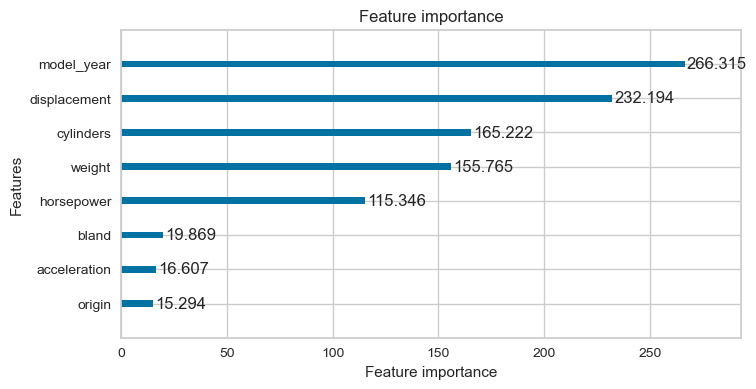

In [45]:
lgb.plot_importance(model, max_num_features=8 ,importance_type='gain',figsize=(8,4))#上から特徴量の数

In [46]:
# 最終予測値の計算
final_predict = pd.DataFrame(model.predict(final_test, num_iteration=model.best_iteration),columns=['mpg'])
# 提出用ファイルのクラス列に予測結果を代入する
sub=pd.read_csv('sample_submit.csv',header=None,names=['id','mpg'])
sub['mpg'] = final_predict['mpg']
sub['mpg'] = sub['mpg'].astype(int) #intにしていることに注意
sub

,id,mpg
0,1,13
1,2,23
2,4,20
3,5,34
4,6,35
...,...,...
194,391,15
195,392,13
196,393,15
197,394,25


In [47]:
sub.to_csv('sub.csv',header=False,index=False)

# SHAP値の確認

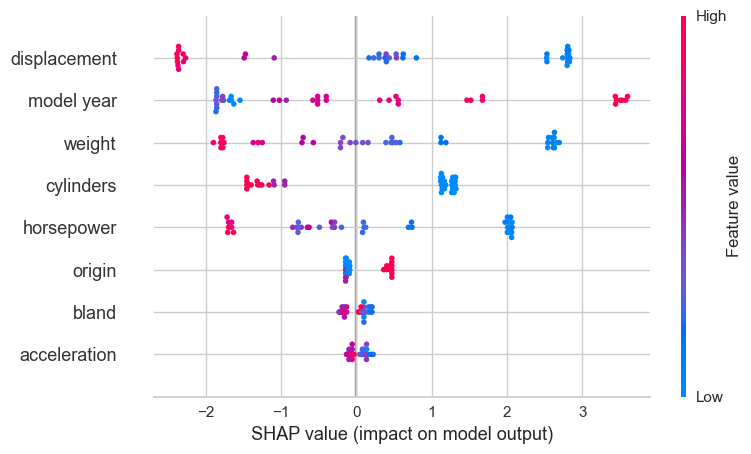

In [48]:
import shap
shap.initjs() #jupyterで使うために必要

explainer = shap.Explainer(model) #TreeExplainerでも多分変わらないが・・
X_test_shap = X_test.copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_test_shap)
shap.summary_plot(shap_values, X_test_shap) 

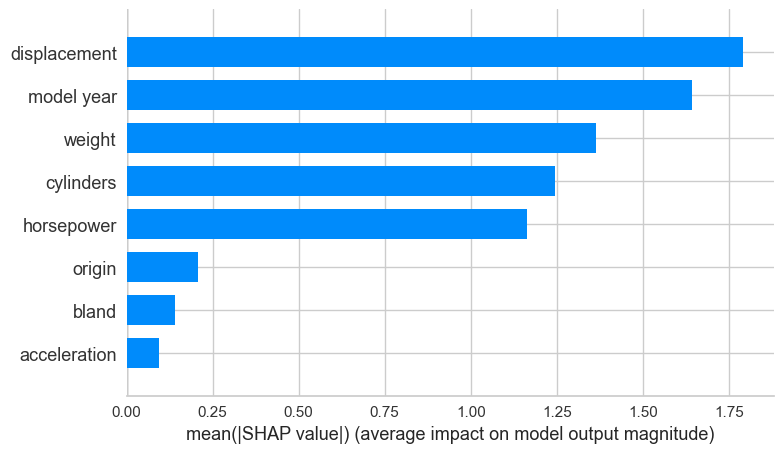

In [49]:
shap.summary_plot(shap_values, X_test_shap, plot_type='bar') 

In [50]:
shap.force_plot(explainer.expected_value, shap_values, X)

<class 'shap._explanation.Explanation'>


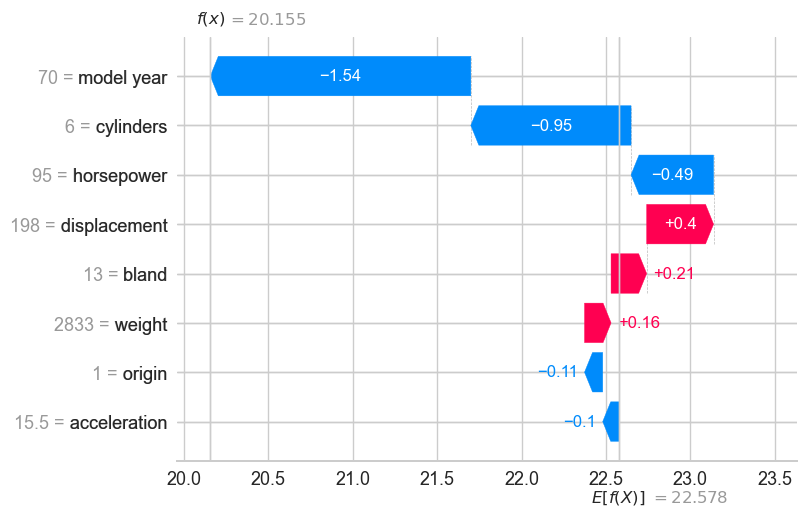

In [51]:
exp = explainer(X_test_shap)
print(type(exp))
shap.plots.waterfall(exp[0])